# Preface
This preface imports libraries to support the simulation.  Feel free to ignore it and skip stragiht to the Abstract

In [1]:
%pylab inline
import numpy as np

# Import libraries defined elsewhere in this repo.
import financial as financial
import li_ion as liion

# Include plotting functions.
exec(open("figure_plotters.py").read())

Populating the interactive namespace from numpy and matplotlib


# Abstract
In this report we will calculate the value of installing a flywheel grid energy storage system and compare it directly to a similarly sized lithium ion battery installation.  This work focuses on the *relative* profits of Lithium Ion versus Flywheel installation.  The reported *absolute* profits have very high uncertainty.  For example, the cost of the electronics used to feed the DC bus are common to both systems, so they are ignored.

This report aims to compare the two storage technologies by comparing the present value of their revenues, operation and maintenance costs, and initial capital cost.  The cumulative present value plots at the end of the report are the summary.

# Parameters
First we will define system parameters.

In [2]:
def PhysicalConstants():
    c = {
    'J_per_kWh': 3600e3,  # [J/kWh]
    'sec_per_hour': 3600.0,  # [sec/hour]
    }
    return c

def CommonParameters():
    pm = {
    # Daily energy storage request specified in kWh.
    'daily_storage_request': 29.0 * c['J_per_kWh'],  # [J]

    # Discount rate.
    'annual_discount_rate': 0.07,  # [#]

    # Purchase Price of Energy, specified in $/kWh.
    'purchase_price': 0.03/c['J_per_kWh'],  # [$/J]

    # Sale Price of Energy specified in $/kWh.
    'sale_price': 0.15/c['J_per_kWh'],  # [$/J] 
    
    # Year the project is built.
    'start_year': 2017,  # [calendar year]
        
    # Time between charge and discharge each day, specified in hours.
    'time_stored': 4.0 * c['sec_per_hour']  # [sec]
    }
    return pm

def BatteryParameters():
    pm_bat = {
    # Initial capacity specified in kWh. The 1.15 factor was tuned to find
    # the most profitable capacity. If capacity is too small then the batteries wear out
    # very quickly, if it is too large then initial capital cost is too large.
    'capacity_0': 29.0 * 1.15 * c['J_per_kWh'], # [J]
        
    # The round trip efficiency.
    'eff_round_trip': 0.80,  # [#]
        
    # Operations and Maintenance cost, specified in $/kWh/year.  SWAG!!
    'O_and_M_cost': 10.0 / c['J_per_kWh'] / 365.0,  # [$/J/day]
    }
    return pm_bat

def FlywheelParameters():
    c = PhysicalConstants()

    system = {
    # Rated energy storage.
    'rated_energy': 29.0 * c['J_per_kWh'], # [J]

    # Power electronics power rating.
    'rated_power': 6.25e3,  # [W]
        
    # Parasitic power loss due to bearing, windage, eddy currents, etc.
    'parasitic_power_loss': 250.0,  # [W]
        
    # The round trip efficiency includes all of the losses from motoring and generation mode but
    # does not include the parasitic power loss during storage.
    'eff_round_trip': 0.89, # [#]
    }

    steel = {
    # Yield strength of tool steel.
    'yield_strength': 1e9,  # [Pa]
    
    # Safety factor on yield strength.
    'sf_yield': 1.5,  # [#]
    
    # Poisson's ratio for steel.
    'poisson_ratio': 0.29,  # [#]

    # Density of steel.
    'density': 8000.0,  # [kg/m3]
    }
    
    financials = {
    # Operations and Maintenance cost, specified in $/kWh/year.  SWAG!!
    'O_and_M_cost': 100.0 / c['J_per_kWh'] / 365.0,  # [$/J/day]
 
    # Motor controller cost estimate.
    'mc_cost_per_watt': 0.10,  # [$/W]

    # Motor cost estimate.  In this case, the windings.
    'winding_cost_per_watt': 0.10,  # [$/W]
    
    # Typical cost for formed steel.
    'steel_cost': 1.00,  # [$/kg]
    }

    pm_fw = {'system': system,
             'steel': steel,
             'financials': financials}
    return pm_fw

# Make the parameters global.
c = PhysicalConstants()
pm = CommonParameters()
pm_fw = FlywheelParameters()
pm_bat = BatteryParameters()

# Initial Capital Cost
Items that are common between the flywheel system and the lithium ion system are not considered.  That includes the power electronics that create the DC bus power, the electrical infrastructure, and the civil works installation costs.  We ~will~ consider the ICC of the factory-produced parts.

## Flywheel Sizing
When using a cylindrical rotor, the rated energy and material properties determine the mass of the rotor.  Any shape cylinder with a particular mass and made of a given material, will be capable of storing the same energy.  The following function designs a cylindrical flywheel rotor. 

In [3]:
def DesignCylindricalFlywheel(energy, yield_strength, poisson_ratio, density, sf_yield):
    """Find the design parameters of the flywheel rotor based on the energy storage 
       capacity and material properties.
    
    Args:
        energy: The energy storage capacity.
        yield_strength: The yield strength of the rotor material.
        poisson_ratio: The Poisson's Ratio of the rotor material.
        density: The density of the rotor material.
        sf_yield: The safety factor applied to yield strength.
    
    Returns:
        The mass, length, and radius of the cylindrical rotor.
    
    Ref:
        Davey, Hebner, "A Fundamental Look At Energy Storage Focusing Primarily
        On Flywheels And Superconducting Energy Storage"
    """
    specific_energy = 2.0 * (yield_strength/sf_yield) / (density * (3.0 + poisson_ratio))

    # Find the mass.
    m = energy/specific_energy

    # Assume the flywheel has the same length and radius.  This should be sufficient to 
    # prevent the first bending mode.
    volume = m/density
    r = (volume/np.pi)**(1/3)
    l = r

    return m, l, r, specific_energy

Now use the flywheel rotor design function to design a rotor for rated energy specified in the parameters.

In [4]:
# Design the flywheel rotor.
(m, l, r, specific_energy) = DesignCylindricalFlywheel(
    pm_fw['system']['rated_energy'],
    pm_fw['steel']['yield_strength'],
    pm_fw['steel']['poisson_ratio'],
    pm_fw['steel']['density'],
    pm_fw['steel']['sf_yield'])

PrintMLR(m, l, r, specific_energy)


Cylindrical Flywheel Specs (rotor only):
mass            =  2061 kg
radius          =  0.43 m
length          =  0.43 m
specific energy =  14.1 Wh/kg
energy density  = 112.6 Wh/L


## Flywheel Initial Capital Cost
Here we find the cost of the manufactured flywheel system by making estimates for each of the subsystems.

In [5]:
cost = {}

# Assume the cost of rotor scales with mass
cost['rotor'] = pm_fw['financials']['steel_cost'] * m

cost['rotor_machining'] = 0.2 * cost['rotor']

# Assume a portion of the rotor mass is required for the casing.
cost['casing'] = 0.5 * cost['rotor']

# Assume the bearings scale with rotor mass.
cost['bearings'] = 0.15 * m

# Assume the mag lev system cost scales with rotor mass.
cost['mag_lev'] = 0.4 * m

# Assume the cost of windings scale with power.
cost['windings'] = pm_fw['financials']['winding_cost_per_watt'] * pm_fw['system']['rated_power']

# Assume the cost of power electronics scale with power.
cost['mc'] = pm_fw['financials']['mc_cost_per_watt'] * pm_fw['system']['rated_power']

# Swag a cost at the vacuum system.
cost['vacuum'] = 400.0  # Swag.

# What did I miss?
cost['extras'] = 3000.0

# Sum up the costs.
total_flywheel_icc = sum([cost[k] for k in cost])

PrintFlywheelCosts(cost, total_flywheel_icc, pm_fw['system']['rated_energy'])


Component          Cost [$]   Cost[$/kWh]
-----------------------------------------
rotor               2060.86         71.06
rotor_machining      412.17         14.21
casing              1030.43         35.53
bearings             309.13         10.66
mag_lev              824.34         28.43
windings             625.00         21.55
mc                   625.00         21.55
vacuum               400.00         13.79
extras              3000.00        103.45
-----------------------------------------
TOTAL               9286.93        320.24


## Battery Initial Capital Cost
Estimates of lithium ion costs are wide ranging.  CleanTechnica [1] has a nice plot summarizing the spread.  

<img src="images/EV-Battery-Prices.png" style="height: 400px;">

For the purpose of estimating lithium ion cell ICC and replacement costs, we will fit an exponential decay roughly equivalent to the black line above, and asymptotic to `$`100/kWh.


[1] <a "href:http://www.nature.com/articles/nclimate2564.epdf?referrer_access_token=H9Rj7kdKUhrhz6Fb5ewzM9RgN0jAjWel9jnR3ZoTv0M00Vb3KgW1MD8qozWNCeynzkwpvLxVPLibQoJbfe-QKEu0ppgTXvcLlb8Vwz_nzK-yAn8RNMmZvOHZVqZQEn1U5XojC5FhPiQ23mWhSt0_N5L3eb1jQZedFMZw2y16duSxwzW7OVQ-V925n7gY-a1vMmlwPWTvamnQjRcKxGJMdFJW6rBZct3i6H7-3u7oczw%3D&tracking_referrer=thinkprogress.org"> Rapidly falling costs of battery packs for electric vehicles, Nature</a>

Selected Points from the trend line
Year    Price [$/kWh]
2017     242
2022     155


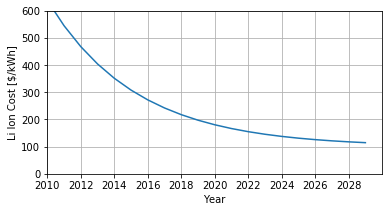

In [6]:
def LiIonCost(year):
    """Return the cost of Li Ion batteries in a given year in $/J"""
    return (1150.0*exp(-0.19*(year-2006.0)) + 100.0) / c['J_per_kWh']

PlotLiIonCost()

# Operation
## Define the Market
It's unknown to me how the market for grid energy storage will function, so to make progress, I've made some assumptions.  These assumptions have a large effect on absolute revenue and profit, but my guess is that since they effect the lithium ion and flywheel storage in a similar way, the comparison of relative revenue remains valid.

* Assume that every day a peaker plant runs during peak demand and any storage added to the grid reduces the peaker plant's load.  Therefore, there is always opportunity to store as much energy as the storage provider wishes.  
* Assume that the peak deficit in production lags peak over-production by 4 hours.
* Assume the storage provider makes revenue by buying power at a low purchase price and selling it back later at a higher selling price.

## Flywheel Revenue and Costs

The following function will represent the daily cycle.  It will be run for each day in the expected life of the installation.

In [7]:
def FlywheelDailyCycle(E_charge, purchase_price, sale_price, eff_round_trip, time_stored, parasitic_power_loss):
    E_discharge = eff_round_trip * E_charge - time_stored * parasitic_power_loss
    revenue = E_discharge * sale_price - E_charge * purchase_price
    cost = pm_fw['financials']['O_and_M_cost']
    return E_discharge, revenue, cost

## Battery Revenue and Costs
### Battery Capacity Deterioration
Battery capacity deteriorates with several variables including temperature, speed-of-charge, and number and depth of charge cycles.  Here I base battery capacity deterioration solely on the number and depth of charge cycles.  The following plot shows the life data used in this analysis.

As shown in the plot, when charge cycles are to a depth of discharge
of 75%, the battery capacity will be 60% of its initial capacity after 3733 cycles.


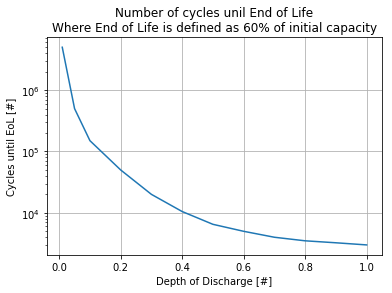

In [8]:
PlotBatteryLife60()

This data is the basis of a function named <code>UpdateBatteryCapacity()</code> defined in <code>li_ion.py</code>.  It is used to reduce the battery capacity each time the battery stores and releases energy in the simulation. Now that we have a function for reducing battery capacity with age, we can write a function to estimate battery revenues and costs during operation.  The following function will represent the daily cycle.  It will be run for each day in the expected life of the installation.

In [9]:
def BatteryDailyCycle(E_charge_req, purchase_price, sale_price, eff_round_trip, capacity_0, capacity, day_num):
    E_charge = min(capacity, E_charge_req)
    E_discharge = eff_round_trip * E_charge
    revenue = E_discharge * sale_price - E_charge * purchase_price
    
    # Every time the battery is used, its capacity is reduced.
    capacity = liion.UpdateBatteryCapacity(capacity_0, capacity, E_charge)
    
    cost = pm_bat['O_and_M_cost']
    # If the capacity falls below a threshold, then buy a new set of cells.
    if capacity < 0.6 * capacity_0:
        capacity = capacity_0
        cost += capacity_0 * LiIonCost(day_num/365.0 + pm['start_year'])
    return (E_discharge, revenue, cost, capacity)

# Financial Simulation

Flywheel_PV - LiIon_PV = Flywheel Advantage
       2996 -     -632 = $3628


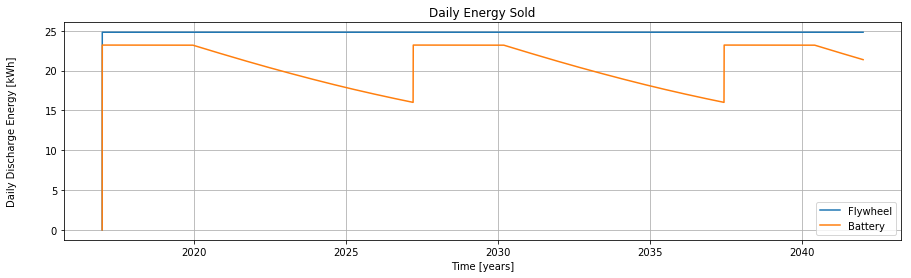

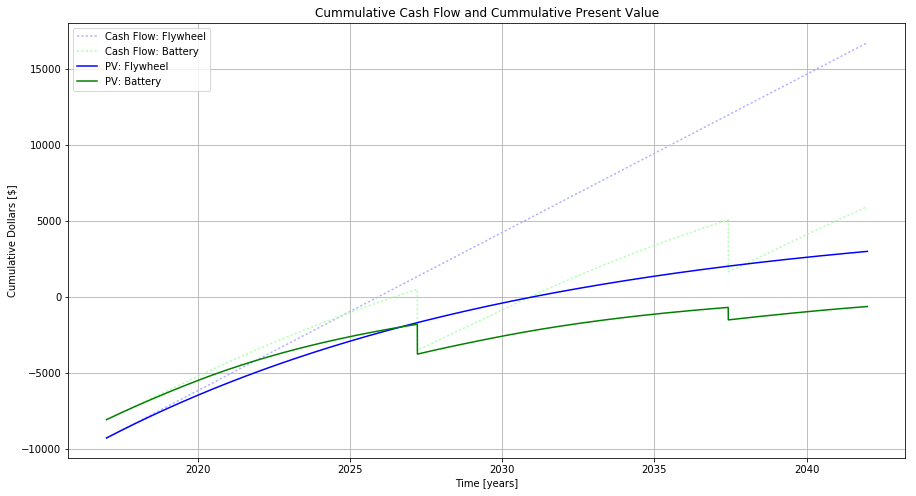

In [10]:
# Number of days of operation.
n = 365 * 25  # [days]

# Initialize the output and state vectors.
E_discharge_fw = np.zeros(n)
revenues_fw = np.zeros(n)
costs_fw = np.zeros(n)

E_discharge_bat = np.zeros(n)
revenues_bat = np.zeros(n)
costs_bat = np.zeros(n)
capacities_bat = np.zeros(n)

# Set initial capital costs to the first element of the vectors.
costs_fw[0] = total_flywheel_icc
costs_bat[0] = LiIonCost(pm['start_year']) * pm_bat['capacity_0']
capacities_bat[0] = pm_bat['capacity_0']

for i in range(1, n):
    (E_discharge_fw[i], revenues_fw[i], costs_fw[i]) = FlywheelDailyCycle(
        pm['daily_storage_request'],
        pm['purchase_price'],
        pm['sale_price'],
        pm_fw['system']['eff_round_trip'],
        pm['time_stored'],
        pm_fw['system']['parasitic_power_loss'])
    
    (E_discharge_bat[i], revenues_bat[i], costs_bat[i], capacities_bat[i]) = BatteryDailyCycle(
        pm['daily_storage_request'],
        pm['purchase_price'],
        pm['sale_price'],
        pm_bat['eff_round_trip'],
        pm_bat['capacity_0'],
        capacities_bat[i-1],
        i)

# Find the present value of the each future cash flow.
discount_rate = pm['annual_discount_rate']/365.0  # [#]  The daily discount rate.
present_value_fw = financial.PV(discount_rate, revenues_fw - costs_fw)
present_value_bat = financial.PV(discount_rate, revenues_bat - costs_bat)

########
# Plot #
########
year = pm['start_year'] + np.array(range(n))/365.0

figure(figsize=(15, 4))
plot(year, E_discharge_fw/c['J_per_kWh'], label="Flywheel")
plot(year, E_discharge_bat/c['J_per_kWh'], label="Battery")
legend()
grid("on")
title("Daily Energy Sold")
ylabel("Daily Discharge Energy [kWh]\n\n")
xlabel("Time [years]");


figure(figsize=(15, 8))
plot(year, cumsum(revenues_fw - costs_fw), color=[.7, .7, 1], linestyle=":", label="Cash Flow: Flywheel")
plot(year, cumsum(revenues_bat - costs_bat), color=[.7, 1, .7], linestyle=":", label="Cash Flow: Battery")
plot(year, cumsum(present_value_fw), "b", label="PV: Flywheel")
plot(year, cumsum(present_value_bat), "g", label="PV: Battery")
legend()
grid("on")
title("Cummulative Cash Flow and Cummulative Present Value")
ylabel("Cumulative Dollars [$]")
xlabel("Time [years]");

# Compare the flywheel and battery after 25 years.
pv_fw = sum(present_value_fw)
pv_bat = sum(present_value_bat)
print("Flywheel_PV - LiIon_PV = Flywheel Advantage")
print("%11.0f - %8.0f = $%4.0f" % (pv_fw, pv_bat, pv_fw - pv_bat))

# Conclusion
Given my (imperfect) inputs and calculations, when making an investment of about `$`10k in grid storage, the present value of the returns from flywheels compared to Lithium Ion batteries, are about `$`3.5k more over the course of 25 years.  This appears to be roughly true for a wide range of power prices.

Although not shown in the report, when the project start date is moved to 2024 or later, Lithium Ion batteries become the marginally better investment due to their asymptotically-decreasing cost.


# Potential Next Steps
* The use of a discount rate implicitly assumes that the utility wants to compare the investment in energy storage to an investment in the financial market. However, the utility must invest in ~something~ to supply power during peak demand, so it may be more accurate to compare these storage investments to an investment in the traditional peak shaving strategy: a natural gas peaker plant.
* Move most of the code from this notebook to .py files and find a way to automatically find input sensitivity.
* More detailed estimates of the other costs associated with the initial installation and maintenance of batteries.  For example, is a cooling system required?
* Itemize installation costs.  A large percentage of the ICC for both systems will be installation.  If one of the systems is especially inexpensive to install, that could be the deciding factor.